# Step 1: Import Requirements

In [45]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns

from FeatureEngineering.stable_state_feature_engineer import Model


# Step 1: Get Data

In [46]:
df = pd.read_csv('DataCache/BT4222 Data Payload.csv').drop(columns = ['Unnamed: 0', 
                                                            'CBOE Emerging Markets ETF Volatility Index', 
                                                            'Total Nonfarm Private Payroll Employment',
                                                            'CBOE EuroCurrency ETF Volatility Index',
                                                            'Assets: Central Bank Liquidity Swaps: Central Bank Liquidity Swaps: Wednesday Level'
                                                            ])
df.index = pd.to_datetime(df['index']).rename('Date')
df = df.drop(columns = ['index'])
df

#get the latest start time
start = datetime.datetime(1950,1,1)
for i in df.columns:
    i_start = df[i].to_frame().dropna().first_valid_index()
    if i_start > start:
        start = i_start

#get end of month values
df = df.fillna(method = 'bfill').resample('M').last().loc[start:]

#target variable
us10y = pd.read_csv('DataCache/US10Y.csv')
us10y.index = pd.to_datetime(us10y.Date)
us10y = us10y['adjusted_close'].rename('US10Y').to_frame().resample('M').mean()
us10y

df = us10y.merge(df, how = 'outer', left_index = True, right_index = True)

#normalize selected metrics by calculating YoY % Change
for i in [ 'ICE BofA AAA US Corporate Index Total Return Index Value',
          'ICE BofA CCC & Lower US High Yield Index Total Return Index Value',
          'CBOE Volatility Index: VIX',
          'Total Borrowings of Depository Institutions from the Federal Reserve',
          'Borrowings, All Commercial Banks',
          'ICE BofA US Emerging Markets Liquid Corporate Plus Index Total Return Index Value',
          'Assets: Securities Held Outright: U.S. Treasury Securities: All: Wednesday Level',
          'Retail Sales',
          'Industrial Production',
          'Core PCE']:
    df[i] = df[i].pct_change(12).replace(np.inf, np.nan)
    

#importing sentiment scores
mw = pd.read_csv('DataCache/marketwatch_sentiment.csv')
mw.index = pd.to_datetime(mw.date).rename('Date')

ny = pd.read_csv('DataCache/newyorktimesbusiness_sentiment.csv')
ny.index = pd.to_datetime(ny.date).rename('Date')

fomc = pd.read_csv('DataCache/FOMCmthData.csv')
fomc['Date'] = fomc['dm'].apply(lambda x: datetime.datetime(int(x[:4]), int(x[-2:]) if len(x) == 7 else int(x[-1]),1))
fomc.index = pd.to_datetime(fomc.Date)
fomc = fomc['compound'].rename('FOMC Sentiment').to_frame()

sentiment = mw.sentimScaled.rename('MarketWatch Sentiment').to_frame().merge(ny.sentimScaled.rename('NewYorkTimes Sentiment'), how = 'outer', left_index = True, right_index = True)
sentiment = sentiment.merge(fomc, how = 'outer', left_index = True, right_index = True).resample('M').mean().fillna(method = 'ffill')

#stable state model - economic indicators only
ss_only = df.dropna()
#stable state + sentiment premium
ss_sp = ss_only.merge(sentiment, how = 'inner', left_index = True, right_index = True)

ss_sp

,US10Y,US OECD CLI,Initial Claims,Continued Claims (Insured Unemployment),"KC Fed Labor Market Conditions Index, Level of Activity Indicator",University of Michigan: Consumer Sentiment,ICE BofA AAA US Corporate Index Total Return Index Value,ICE BofA CCC & Lower US High Yield Index Total Return Index Value,ICE BofA US Emerging Markets Liquid Corporate Plus Index Total Return Index Value,CBOE Volatility Index: VIX,Assets: Securities Held Outright: U.S. Treasury Securities: All: Wednesday Level,Total Borrowings of Depository Institutions from the Federal Reserve,"Borrowings, All Commercial Banks",Total Business: Inventories to Sales Ratio,Retail Sales,Industrial Production,Core PCE,MarketWatch Sentiment,NewYorkTimes Sentiment,FOMC Sentiment
Date,,,,,,,,,,,,,,,,,,,,
2004-12-31,4.221364,100.474134,356000.0,2672000.0,0.21040,95.5,0.045260,0.157526,0.091600,-0.274167,0.076734,-0.169231,0.071149,1.29,0.063758,0.038112,0.021711,NaN,NaN,0.294429
2005-01-31,4.209550,100.417665,307000.0,2710000.0,0.35418,94.1,0.040844,0.110634,0.091730,-0.250731,0.075838,1.652174,0.019844,1.29,0.069857,0.039368,0.021746,NaN,NaN,0.294429
2005-02-28,4.162053,100.346365,333000.0,2658000.0,0.29572,92.6,0.021751,0.148822,0.087590,-0.163435,0.068286,2.375000,0.034938,1.30,0.052755,0.042016,0.022558,NaN,NaN,0.316910
2005-03-31,4.494636,100.292668,335000.0,2653000.0,0.34741,87.7,0.004895,0.118433,0.050865,-0.162485,0.064186,0.468085,0.014187,1.28,0.073539,0.039847,0.021085,NaN,NaN,0.243661
2005-04-30,4.325429,100.279900,334000.0,2596000.0,0.44068,86.9,0.054393,0.072178,0.103524,-0.120419,0.061317,0.272727,0.047667,1.29,0.046917,0.033615,0.021774,NaN,NaN,0.243661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-30,2.740725,99.446028,202000.0,1342000.0,1.40148,58.4,-0.110518,-0.043297,-0.114000,0.737775,0.143800,3.385164,-0.058608,1.30,0.075125,0.044161,0.048815,0.156351,-0.141177,0.159404
2022-05-31,2.905173,99.225935,232000.0,1310000.0,1.37618,50.0,-0.108237,-0.080877,-0.123640,0.463128,0.127320,0.507692,-0.038904,1.30,0.081550,0.038984,0.050354,0.038906,-0.084998,0.132737
2022-06-30,3.128172,99.060610,236000.0,1333000.0,1.39555,51.5,-0.147560,-0.164267,-0.161337,0.813645,0.108223,3.064315,0.116964,1.32,0.100002,0.039458,0.046727,0.062117,-0.103810,0.152140


# Step 3: Start with just the Stable State Model

In [47]:
ss_only_model = Model(df.dropna(), 'US10Y')
models = ss_only_model.search_for_optimal_model().sort_values('Testing RMSE', ascending = True)
models

c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.737e-02, tolerance: 1.822e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e-02, tolerance: 1.822e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.64117e-17): result may not be acc

,Model Name,Model,Features,# of Features,Training RMSE,Testing RMSE
27,Random Forest Regressor Model (ccp_alpha = 0),"(DecisionTreeRegressor(ccp_alpha=0, max_depth=...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.251973,0.373069
22,Random Forest Regressor Model (ccp_alpha = 0),"(DecisionTreeRegressor(ccp_alpha=0, max_depth=...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.321688,0.428798
17,Random Forest Regressor Model (ccp_alpha = 0),"(DecisionTreeRegressor(ccp_alpha=0, max_depth=...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.408638,0.504594
23,Random Forest Regressor Model (ccp_alpha = 0.1),"(DecisionTreeRegressor(ccp_alpha=0.1, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.513364,0.555621
28,Random Forest Regressor Model (ccp_alpha = 0.1),"(DecisionTreeRegressor(ccp_alpha=0.1, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.513145,0.556413
18,Random Forest Regressor Model (ccp_alpha = 0.1),"(DecisionTreeRegressor(ccp_alpha=0.1, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.516408,0.558959
29,Random Forest Regressor Model (ccp_alpha = 0.2),"(DecisionTreeRegressor(ccp_alpha=0.2, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.717190,0.741357
24,Random Forest Regressor Model (ccp_alpha = 0.2),"(DecisionTreeRegressor(ccp_alpha=0.2, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.717190,0.741357
19,Random Forest Regressor Model (ccp_alpha = 0.2),"(DecisionTreeRegressor(ccp_alpha=0.2, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.717190,0.741357
25,Random Forest Regressor Model (ccp_alpha = 0.5),"(DecisionTreeRegressor(ccp_alpha=0.5, max_dept...","[US OECD CLI (Leading by 6 Months), US OECD CL...",32,0.795770,0.829568


#### Let's look at our base model first, which is a standard Linear Regression on all time shifted features

In [48]:
base_model = models[models['Model Name'] == 'Base Model - Linear Regression']

print(base_model['Model Name'][0])
print('Training RMSE:', round(base_model['Training RMSE'][0],2))
print('Testing RMSE:', round(base_model['Testing RMSE'][0],2))

Base Model - Linear Regression
Training RMSE: 0.48
Testing RMSE: 1.97


#### Let's take a look at our Stable State Model now

RandomForestRegressor(ccp_alpha=0, max_depth=5, random_state=42)
Training RMSE: 0.25
Testing RMSE: 0.37
RMSE on both training and test set outperform the base model!


<AxesSubplot:title={'center':'US10Y Model'}, xlabel='Date'>

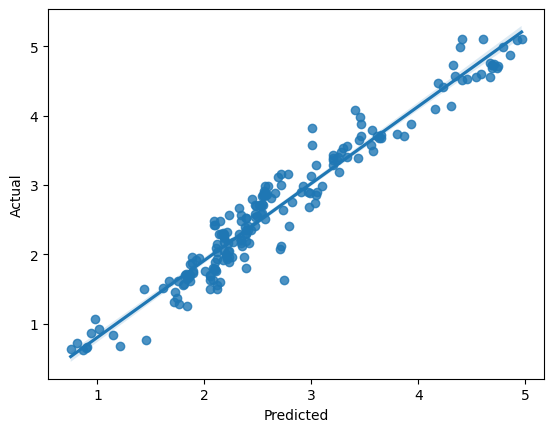

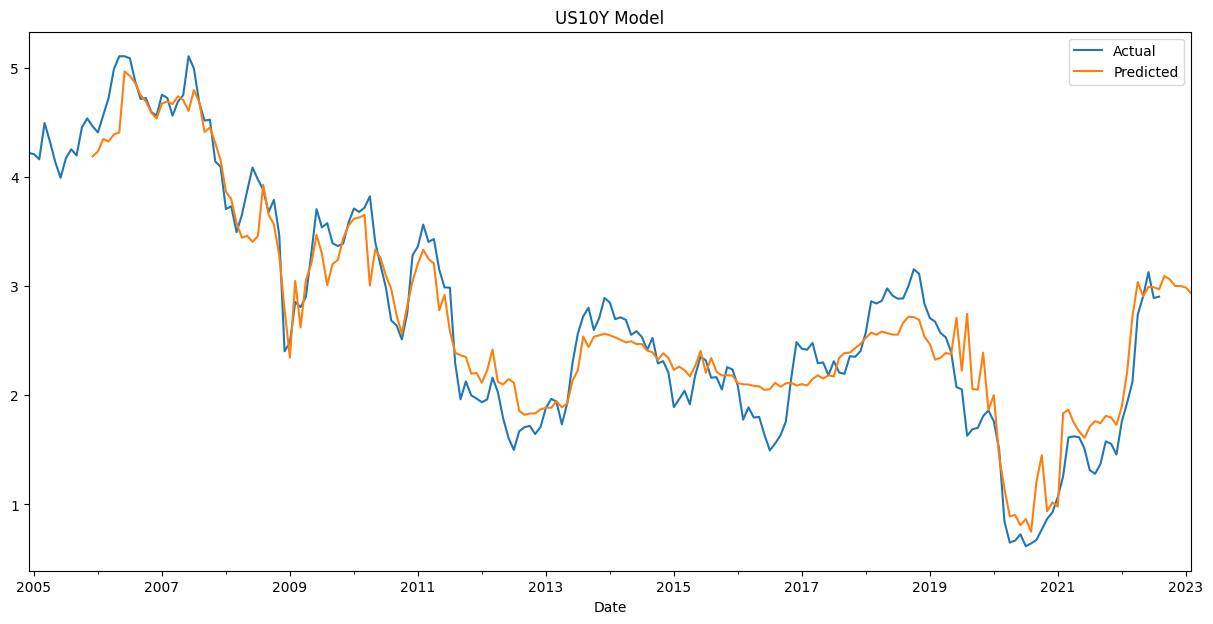

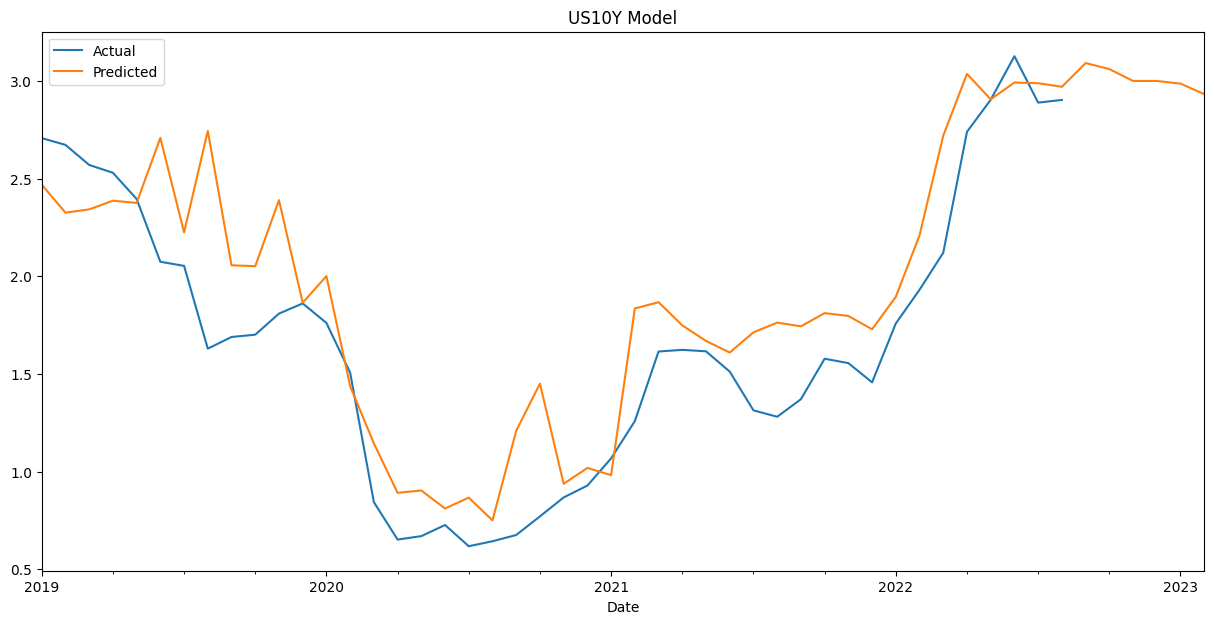

In [49]:
best = models.iloc[0]
best_model = best['Model']
print(best_model)
print('Training RMSE:', round(best['Training RMSE'],2))
print('Testing RMSE:', round(best['Testing RMSE'],2))
print('RMSE on both training and test set outperform the base model!')
best_features = best['Features']

pred = ss_only_model.time_shifted_feature_dataframe[best_features].dropna()
pred['Predicted'] = best_model.predict(pred)

output = ss_only_model.target_variable_dataframe.merge(pred['Predicted'], how = 'outer', left_index = True, right_index = True)
output.columns = ['Actual', 'Predicted']

output_df = pd.DataFrame(output)
sns.regplot(x = output_df['Predicted'], y = output_df['Actual'])
output_df.plot(figsize = [15,7], title = 'US10Y Model')
output_df.iloc[-50:].plot(figsize = [15,7], title = 'US10Y Model')

# Step 4: Combine together with the Sentiment Premium Model

#### Add in Sentiment Premiums as part of Stable State Model

c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.776e+01, tolerance: 8.650e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e+01, tolerance: 8.650e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.53578e-17): result may not be acc

Random Forest Regressor Model (ccp_alpha = 0)
Training RMSE: 0.217
Testing RMSE: 0.417


<AxesSubplot:title={'center':'Core PCE Model'}, xlabel='Date'>

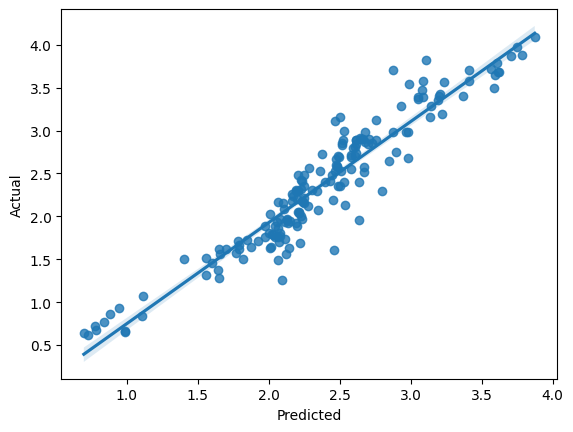

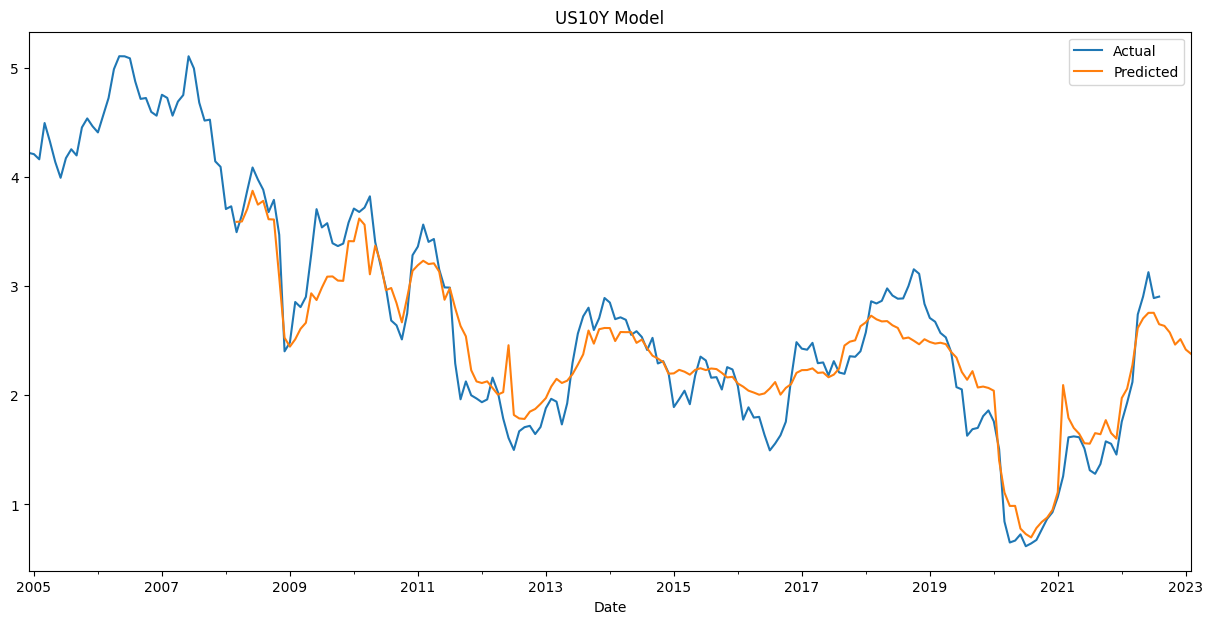

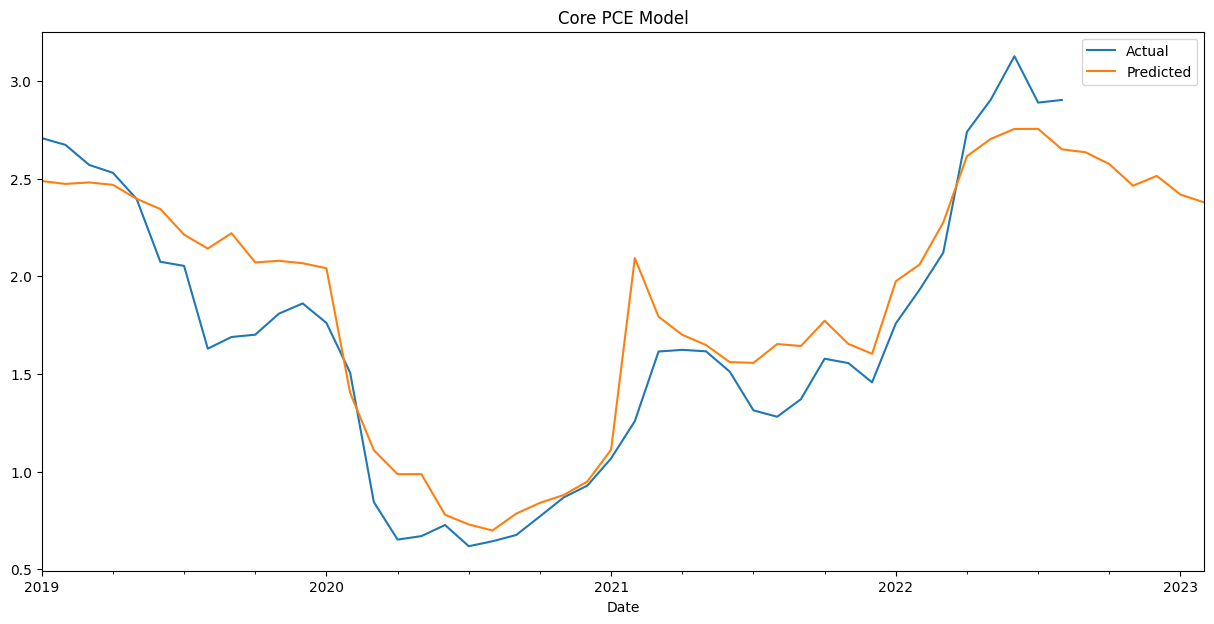

In [50]:
ss_sp_model = Model(ss_sp, 'US10Y')
models = ss_sp_model.search_for_optimal_model().sort_values('Testing RMSE', ascending = True)

best = models.iloc[0]
best_model = best['Model']
best_features = best['Features']

base_model = models[models['Model Name'] == 'Base Model - Linear Regression']

print(best['Model Name'])
print('Training RMSE:', round(best['Training RMSE'],3))
print('Testing RMSE:', round(best['Testing RMSE'],3))

pred = ss_sp_model.time_shifted_feature_dataframe[best_features].dropna()
pred['Predicted'] = best_model.predict(pred)

output = ss_sp_model.target_variable_dataframe.merge(pred['Predicted'], how = 'outer', left_index = True, right_index = True)
output.columns = ['Actual', 'Predicted']

import matplotlib.pyplot as plt
import seaborn as sns

output_df = pd.DataFrame(output)
# output_df = output_df[output_df['Predicted']>-0.2]
scatter_output_df = output_df.dropna()
sns.regplot(data = scatter_output_df, x = 'Predicted', y = 'Actual')
output_df.plot(figsize = [15,7], title = 'US10Y Model')
output_df.iloc[-50:].plot(figsize = [15,7], title = 'Core PCE Model')

#### Create a new stable state model using the prediction of the original stable state model, along with the sentiment scores

In [52]:
ss_only_model = Model(ss_only, 'US10Y')
models = ss_only_model.search_for_optimal_model().sort_values('Testing RMSE', ascending = True)

best = models.iloc[0]
best_model = best['Model']
print(best_model)
best_features = best['Features']

pred = ss_only_model.time_shifted_feature_dataframe[best_features].dropna()
pred['Original Stable State Prediction'] = best_model.predict(pred)

final_stable_state_model_df = ss_only_model.target_variable_dataframe.merge(pred['Original Stable State Prediction'], how = 'outer', left_index = True, right_index = True)
final_stable_state_model_df = final_stable_state_model_df.merge(sentiment, how = 'outer', left_index = True, right_index = True)

final_stable_state_model_df

final_stable_state_model = Model(final_stable_state_model_df, 'US10Y', min_lead = 0, max_lead = 6, unique_timeshifts_accepted = 1)
models = final_stable_state_model.search_for_optimal_model().sort_values('Testing RMSE', ascending = True)
models
# import matplotlib.pyplot as plt
# import seaborn as sns

# output_df = pd.DataFrame(output)
# # output_df = output_df[output_df['Predicted']>-0.2]
# sns.regplot(output_df['Predicted'], output_df['Actual'])
# output_df.plot(figsize = [15,7], title = 'US10Y Model')
# output_df.iloc[-50:].plot(figsize = [15,7], title = 'US10Y Model')

c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.737e-02, tolerance: 1.822e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.669e-02, tolerance: 1.822e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\XDXDX\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.64117e-17): result may not be acc

RandomForestRegressor(ccp_alpha=0, max_depth=5, random_state=42)


TypeError: __init__() got an unexpected keyword argument 'min_lead'

In [58]:
Model(final_stable_state_model_df, 'US10Y',unique_timeshifts_accepted = 1, min_lead = 0, max_lead = 3)

TypeError: __init__() got an unexpected keyword argument 'unique_timeshifts_accepted'